In [ ]:
import os
import numpy as np
import torch

In [6]:
from torch.utils.data import DataLoader
from generate_data import generate_vrp_data
from utils import load_model
from problems import CVRPTW

In [40]:
%matplotlib inline
from matplotlib import pyplot as plt

from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle
from matplotlib.lines import Line2D

# Code inspired by Google OR Tools plot:
# https://github.com/google/or-tools/blob/fb12c5ded7423d524fc6c95656a9bdc290a81d4d/examples/python/cvrptw_plot.py

def discrete_cmap(N, base_cmap=None):
  """
    Create an N-bin discrete colormap from the specified input map
    """
  # Note that if base_cmap is a string or None, you can simply do
  #    return plt.cm.get_cmap(base_cmap, N)
  # The following works for string, None, or a colormap instance:

  base = plt.cm.get_cmap(base_cmap)
  color_list = base(np.linspace(0, 1, N))
  cmap_name = base.name + str(N)
  return base.from_list(cmap_name, color_list, N)

def plot_vehicle_routes(data, route, t, ax1, markersize=5, visualize_demands=False, demand_scale=1, round_demand=False):
    """
    Plot the vehicle routes on matplotlib axis ax1.
    """
    print(route)
    print(data['time_window'])
    print(t)
    # route is one sequence, separating different routes with 0 (depot)
    routes = [r[r!=0] for r in np.split(route.cpu().numpy(), np.where(route==0)[0]) if (r != 0).any()]
    depot = data['depot'].cpu().numpy()
    locs = data['loc'].cpu().numpy()
    demands = data['demand'].cpu().numpy() * demand_scale
    print("demands:",demands)
    capacity = demand_scale # Capacity is always 1
    
    x_dep, y_dep = depot
    ax1.plot(x_dep, y_dep, 'sk', markersize=markersize*4)
    ax1.set_xlim(10, 60)
    ax1.set_ylim(40, 90)
    
    legend = ax1.legend(loc='upper center')
    
    cmap = discrete_cmap(len(routes) + 2, 'nipy_spectral')
    dem_rects = []
    used_rects = []
    cap_rects = []
    qvs = []
    total_dist = 0
    for veh_number, r in enumerate(routes):
        color = cmap(len(routes) - veh_number) # Invert to have in rainbow order
        
        route_demands = demands[r - 1]
        coords = locs[r - 1, :]
        xs, ys = coords.transpose()

        total_route_demand = sum(route_demands)
        print(total_route_demand,capacity)
        assert total_route_demand <= capacity+1
        if not visualize_demands:
            ax1.plot(xs, ys, 'o', mfc=color, markersize=markersize, markeredgewidth=0.0)
        
        dist = 0
        x_prev, y_prev = x_dep, y_dep
        cum_demand = 0
        for (x, y), d in zip(coords, route_demands):
            dist += np.sqrt((x - x_prev) ** 2 + (y - y_prev) ** 2)
            
            cap_rects.append(Rectangle((x, y), 0.01, 0.1))
            used_rects.append(Rectangle((x, y), 0.01, 0.1 * total_route_demand / capacity))
            dem_rects.append(Rectangle((x, y + 0.1 * cum_demand / capacity), 0.01, 0.1 * d / capacity))
            
            x_prev, y_prev = x, y
            cum_demand += d
            
        dist += np.sqrt((x_dep - x_prev) ** 2 + (y_dep - y_prev) ** 2)
        total_dist += dist
        qv = ax1.quiver(
            xs[:-1],
            ys[:-1],
            xs[1:] - xs[:-1],
            ys[1:] - ys[:-1],
            scale_units='xy',
            angles='xy',
            scale=1,
            color=color,
            label='R{}, # {}, c {} / {}, d {:.2f}'.format(
                veh_number, 
                len(r), 
                int(total_route_demand) if round_demand else total_route_demand, 
                int(capacity) if round_demand else capacity,
                dist
            )
        )
        
        qvs.append(qv)
        
    ax1.set_title('{} routes, total distance {:.2f}'.format(len(routes), total_dist))
    ax1.legend(handles=qvs)
    
    pc_cap = PatchCollection(cap_rects, facecolor='whitesmoke', alpha=1.0, edgecolor='lightgray')
    pc_used = PatchCollection(used_rects, facecolor='lightgray', alpha=1.0, edgecolor='lightgray')
    pc_dem = PatchCollection(dem_rects, facecolor='black', alpha=1.0, edgecolor='black')
    
    if visualize_demands:
        ax1.add_collection(pc_cap)
        ax1.add_collection(pc_used)
        ax1.add_collection(pc_dem)

In [29]:
model, _ = load_model('outputs/cvrptw_25/\'cvrptw25_rollout\'_20190629T184119')
torch.manual_seed(1234)
dataset_path='data/cvrptw/cvrptw25_solomon_seed1234.pkl'
dataset = CVRPTW.make_dataset(filename=dataset_path, size=25, num_samples=5)

  [*] Loading model from outputs/cvrptw_25/'cvrptw25_rollout'_20190629T184119\epoch-1.pt


tensor([13, 22, 21,  0, 19, 23,  2,  1,  0, 18, 16, 14,  4,  0,  8, 15, 12,  0,
        25, 11,  9,  6,  0, 24, 10,  0, 20, 17,  0,  7,  0,  5,  3])
tensor([[912., 967.],
        [825., 870.],
        [ 65., 146.],
        [727., 782.],
        [ 15.,  67.],
        [621., 702.],
        [170., 225.],
        [255., 324.],
        [534., 605.],
        [357., 410.],
        [448., 505.],
        [652., 721.],
        [ 30.,  92.],
        [567., 620.],
        [384., 429.],
        [475., 528.],
        [ 99., 148.],
        [179., 254.],
        [278., 345.],
        [ 10.,  73.],
        [914., 965.],
        [812., 883.],
        [732., 777.],
        [ 65., 144.],
        [169., 224.]])
tensor([ 120.8058,  902.0000, 1004.0000,    0.0000,  368.0000,  822.0000,
         934.6716, 1026.6716,    0.0000,  269.0000,  565.0000,  657.0000,
         817.0000,    0.0000,  345.0000,  474.0000,  742.0000,    0.0000,
         259.0000,  538.0000,  631.1623,  723.3984,    0.0000,  155.0000,
    

No handles with labels found to put in legend.


70.00000190734863 200
60.00000190734863 200
80.0 200
80.0 200
80.0 200
20.0 200
30.0 200
20.0 200
20.0 200
tensor([25, 23, 22, 21, 12,  0, 24, 19, 16, 14,  7,  5,  3,  2,  1,  0, 15, 11,
         9,  6,  4,  0, 10,  0,  8,  0, 20, 18,  0, 13,  0, 17,  0])
tensor([[   0., 1127.],
        [   0., 1125.],
        [   0., 1129.],
        [ 727.,  782.],
        [   0., 1130.],
        [ 621.,  702.],
        [   0., 1130.],
        [ 255.,  324.],
        [ 534.,  605.],
        [ 357.,  410.],
        [ 448.,  505.],
        [   0., 1107.],
        [  30.,   92.],
        [ 567.,  620.],
        [ 384.,  429.],
        [ 475.,  528.],
        [  99.,  148.],
        [ 179.,  254.],
        [ 278.,  345.],
        [  10.,   73.],
        [   0., 1135.],
        [ 812.,  883.],
        [ 732.,  777.],
        [  65.,  144.],
        [ 169.,  224.]])
tensor([ 259.0000,  822.0000,  915.0000, 1007.0000, 1130.3766,    0.0000,
         155.0000,  368.0000,  565.0000,  657.0000,  773.1725,  865.4

No handles with labels found to put in legend.


110.0 200
150.00000190734863 200
90.0 200
10.0 200
20.0 200
30.0 200
30.000001907348633 200
20.0 200
tensor([25, 24, 23, 22, 21, 20,  7,  0, 19, 16, 18, 15, 14, 12,  6,  5,  3,  1,
         0, 17, 11,  9,  4,  2,  0, 13, 10,  0,  8,  0,  0,  0,  0])
tensor([[   0., 1127.],
        [   0., 1125.],
        [   0., 1129.],
        [ 727.,  782.],
        [   0., 1130.],
        [ 621.,  702.],
        [   0., 1130.],
        [ 255.,  324.],
        [ 534.,  605.],
        [ 357.,  410.],
        [ 448.,  505.],
        [   0., 1107.],
        [  30.,   92.],
        [   0., 1106.],
        [ 384.,  429.],
        [   0., 1105.],
        [  99.,  148.],
        [   0., 1110.],
        [   0., 1106.],
        [   0., 1136.],
        [   0., 1135.],
        [ 812.,  883.],
        [ 732.,  777.],
        [   0., 1131.],
        [ 169.,  224.]])
tensor([ 259.0000,  351.0000,  822.0000,  915.0000, 1007.0000, 1099.0000,
        1207.8679,    0.0000,  129.0512,  226.1223,  327.3027,  474.0000,
 

No handles with labels found to put in legend.


130.0 200
190.0 200
80.00000190734863 200
40.00000190734863 200
20.0 200
tensor([25, 24, 23, 22, 21, 20, 10,  0, 19, 18, 17, 16, 15, 14, 12,  7,  6,  0,
        13, 11,  9,  5,  4,  3,  2,  1,  0,  8,  0,  0,  0,  0,  0])
tensor([[   0., 1127.],
        [   0., 1125.],
        [   0., 1129.],
        [ 727.,  782.],
        [   0., 1130.],
        [   0., 1127.],
        [   0., 1130.],
        [ 255.,  324.],
        [ 534.,  605.],
        [   0., 1129.],
        [ 448.,  505.],
        [   0., 1107.],
        [  30.,   92.],
        [   0., 1106.],
        [ 384.,  429.],
        [   0., 1105.],
        [   0., 1112.],
        [   0., 1110.],
        [   0., 1106.],
        [   0., 1136.],
        [   0., 1135.],
        [   0., 1133.],
        [ 732.,  777.],
        [   0., 1131.],
        [ 169.,  224.]])
tensor([ 259.0000,  351.0000,  822.0000,  915.0000, 1007.0000, 1099.0000,
        1205.7631,    0.0000,  129.0512,  224.0512,  317.0512,  417.2493,
         512.2493,  607.6345,

No handles with labels found to put in legend.


120.0 200
200.0 200
120.00000381469727 200
20.0 200
tensor([25, 23, 22, 21,  0, 24, 20, 19, 16, 14, 12,  4,  2,  1,  0, 18, 15, 11,
         0, 17, 10,  0, 13,  9,  0,  8,  0,  7,  0,  6,  0,  5,  3])
tensor([[885., 994.],
        [802., 893.],
        [ 25., 186.],
        [699., 810.],
        [ 15., 120.],
        [580., 743.],
        [142., 253.],
        [220., 359.],
        [499., 640.],
        [331., 436.],
        [420., 533.],
        [617., 756.],
        [ 30., 155.],
        [541., 646.],
        [362., 451.],
        [448., 555.],
        [ 75., 172.],
        [142., 291.],
        [244., 379.],
        [ 10., 137.],
        [888., 991.],
        [776., 919.],
        [709., 800.],
        [ 25., 184.],
        [142., 251.]])
tensor([ 232.0000,  799.0000,  892.0000,  984.0000,    0.0000,  115.0000,
         210.0000,  334.0000,  538.0000,  631.0000,  724.0000,  838.0416,
         931.6472, 1023.6472,    0.0000,  232.0000,  452.0000,  560.6011,
           0.0000,  165.00

No handles with labels found to put in legend.


90.0 200
150.00000190734863 200
70.0 200
30.0 200
40.00000190734863 200
20.0 200
20.0 200
20.0 200
20.0 200


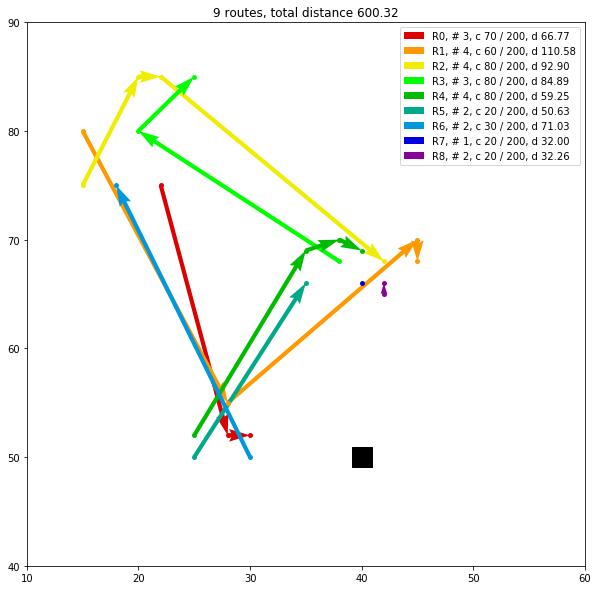

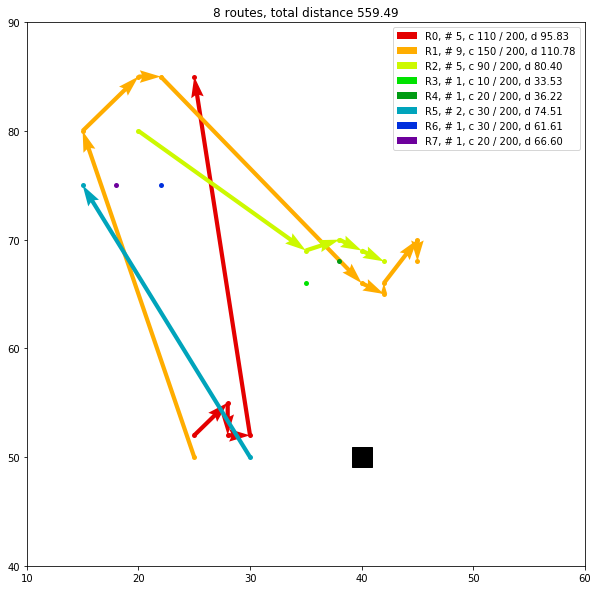

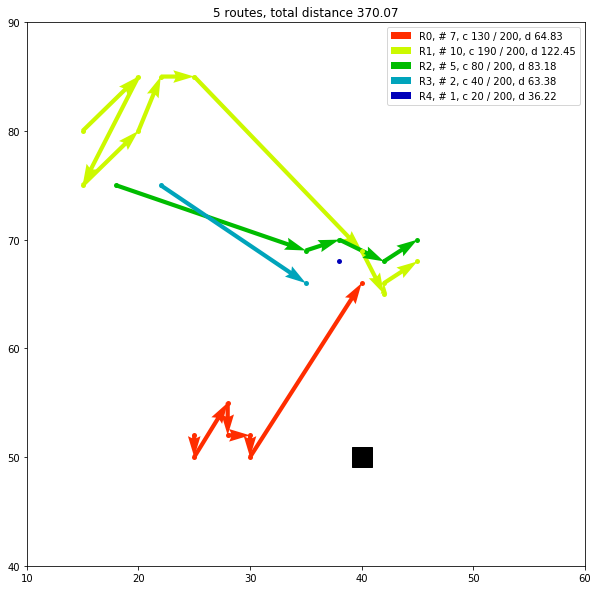

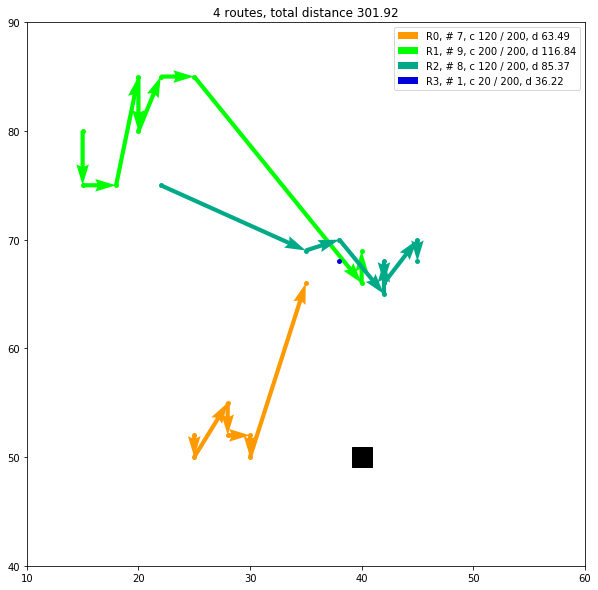

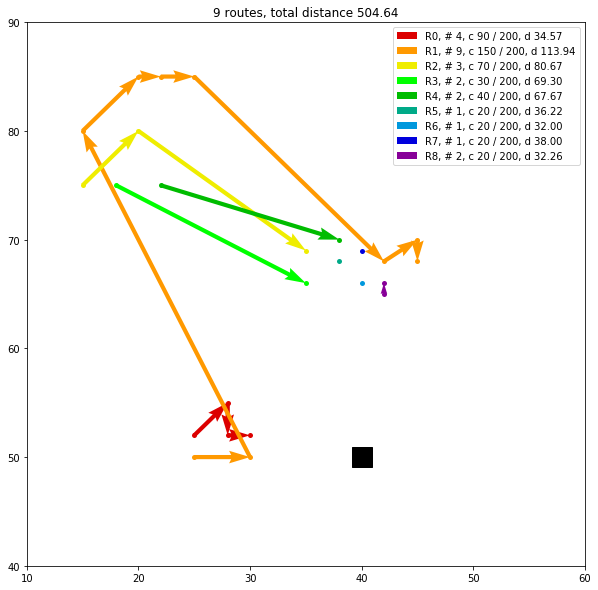

In [41]:
# Need a dataloader to batch instances


# Make var works for dicts
batch = next(iter(dataloader))

# Run the model
model.eval()
model.set_decode_type('greedy')
with torch.no_grad():
    length, log_p, pi, time = model(batch, return_pi=True)
tours = pi
times = time

# Plot the results
for i, (data, tour, t) in enumerate(zip(dataset, tours, times)):
    fig, ax = plt.subplots(figsize=(10, 10))
    plot_vehicle_routes(data, tour, t, ax, visualize_demands=False, demand_scale=200, round_demand=True)
    fig.savefig(os.path.join('images', 'cvrptw_{}.png'.format(i)))